# Analysis deep layer optogenetics 5 - comparison with L2

In [1]:
# works with saved datasets from deep_layer_stimulus_2

In [2]:
# the following two lines indicate that external functions are auto-reloaded as soon as they change. 
%load_ext autoreload
%autoreload 2
# Print statements 
from __future__ import print_function # Python 2.x

In [3]:
# General stuff:
import sys
import argparse
import os
import json
import numpy as np
import math
import psycopg2
import cPickle
import pandas as pd
import h5py
try:
    import statsmodels.nonparametric.api as smnp
    _has_statsmodels = True
except ImportError:
    _has_statsmodels = False
    
from scipy.signal import spectrogram,welch,detrend,butter,filtfilt,hilbert,savgol_filter

pd.options.mode.chained_assignment = None  # default='warn'

from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
from IPython.display import display, HTML

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from analysis_helpers.misshapen import shape, nonshape

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general


In [4]:
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Yippiyeah! Database connection is established!')

Connecting to the PostgreSQL database...
Yippiyeah! Database connection is established!


In [5]:
# load the parameters to connect to data_1 
params = config()

## Analysis

Retrieve stimulus table for deep layer mice (**retro-cre**, **DIOCheta injections**)

In [6]:
salt_i_thresh = .1
salt_p_thresh = .05
inhib_p_thresh = .001 # arbitrary at the moment!

### Retrieve the stuff:

In [7]:
export_path_pickle  = r"C:\work\python\klusta_analysis\postgres_notebooks\export_dataframes"
export_path_pickle = "/".join(export_path_pickle.split("\\"))

In [8]:
# retrieve:
deep_layer_exc_filtered = pd.read_pickle(export_path_pickle + "/deep_layer_exc_filtered.pkl")
deep_layer_inhib_filtered = pd.read_pickle(export_path_pickle + "/deep_layer_inhib_filtered.pkl")
deep_layer_rest_filtered = pd.read_pickle(export_path_pickle + "/deep_layer_rest_filtered.pkl")

deep_layer_autocorr_cells = pd.read_pickle(export_path_pickle + "/autocorr_cells.pkl")
#ratemaps_cells = pd.read_pickle(export_path_pickle + "/ratemaps_cells.pkl")
#obj_ratemaps_cells = pd.read_pickle(export_path_pickle + "/obj_ratemaps_cells.pkl")
deep_layer_bnt_scores_cells = pd.read_pickle(export_path_pickle + "/bnt_scores_cells.pkl")
#spiketimes_tracking_cells = pd.read_pickle(export_path_pickle + "/spiketimes_tracking_cells.pkl")
#obj_spiketimes_tracking_cells = pd.read_pickle(export_path_pickle + "/obj_spiketimes_tracking_cells.pkl")
#tracking_cells = pd.read_pickle(export_path_pickle + "/tracking_cells.pkl")
#obj_tracking_cells = pd.read_pickle(export_path_pickle + "/obj_tracking_cells.pkl")

sup_layer_bnt_scores_cells = pd.read_pickle(export_path_pickle + "/sup_layer_inhib_bnt_scores_cells.pkl")
sup_layer_autocorr_cells = pd.read_pickle(export_path_pickle + "/sup_layer_inhib_autocorr_cells.pkl")

### Work with scores from deep and superficial layers

**You want to analyze**
- deep_layer_autocorr_cells
- deep_layer_bnt_scores_cells

- sup_layer_bnt_scores_cells
- sup_layer_autocorr_cells

In [10]:
len(sup_layer_bnt_scores_cells)

498

In [11]:
deep_layer_exc_bnt_scores_cells = deep_layer_bnt_scores_cells[deep_layer_bnt_scores_cells.excited == True]
deep_layer_inhib_bnt_scores_cells = deep_layer_bnt_scores_cells[deep_layer_bnt_scores_cells.inhibited == True]

### firing frequencies

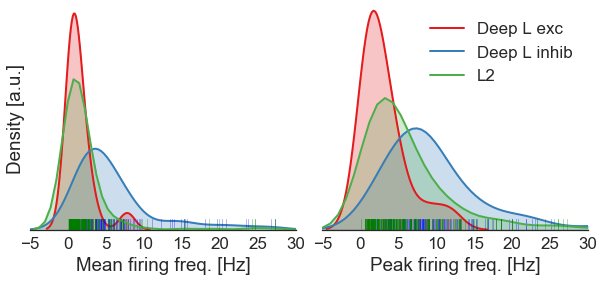

In [12]:
sns.set(font_scale=1.7)
sns.set_style('white')
sns.set_palette('Set1')
figure = plt.figure(figsize=(10,4))
ax = figure.add_subplot(1,2,1)
ax = sns.kdeplot(deep_layer_exc_bnt_scores_cells.meanrate.dropna(), shade=True,label='Deep L exc',lw=2)
ax = sns.rugplot(deep_layer_exc_bnt_scores_cells.meanrate.dropna(),lw=1,color='r',alpha=.3)

ax = sns.kdeplot(deep_layer_inhib_bnt_scores_cells.meanrate.dropna(), shade=True, label='Deep L inhib',lw=2)
ax = sns.rugplot(deep_layer_inhib_bnt_scores_cells.meanrate.dropna(),lw=1,color='b',alpha=.3)

ax = sns.kdeplot(sup_layer_bnt_scores_cells.meanrate.dropna(), 
                 shade=True,label='L2',lw=2)
ax = sns.rugplot(sup_layer_bnt_scores_cells.meanrate.dropna(),lw=1,color='g',alpha=.3)

ax.set_xlabel('Mean firing freq. [Hz]')
ax.set_ylabel('Density [a.u.]')
ax.set_xlim(-5,30)
ax.get_yaxis().set_ticks([])
ax.legend_.remove()

ax = figure.add_subplot(1,2,2)
ax = sns.kdeplot(deep_layer_exc_bnt_scores_cells.peakrate.dropna(), shade=True,label='Deep L exc',lw=2)
ax = sns.rugplot(deep_layer_exc_bnt_scores_cells.peakrate.dropna(),lw=1,color='r',alpha=.3)

ax = sns.kdeplot(deep_layer_inhib_bnt_scores_cells.peakrate.dropna(), shade=True, label='Deep L inhib',lw=2)
ax = sns.rugplot(deep_layer_inhib_bnt_scores_cells.peakrate.dropna(),lw=1,color='b',alpha=.3)

ax = sns.kdeplot(sup_layer_bnt_scores_cells.peakrate.dropna(), 
                 shade=True,label='L2',lw=2)
ax = sns.rugplot(sup_layer_bnt_scores_cells.peakrate.dropna(),lw=1,color='g',alpha=.3)

ax.set_xlabel('Peak firing freq. [Hz]')
ax.set_xlim(-5,30)
ax.get_yaxis().set_ticks([])

figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)

sns.despine(left=True)

### Gridscore, MVL, speedscore

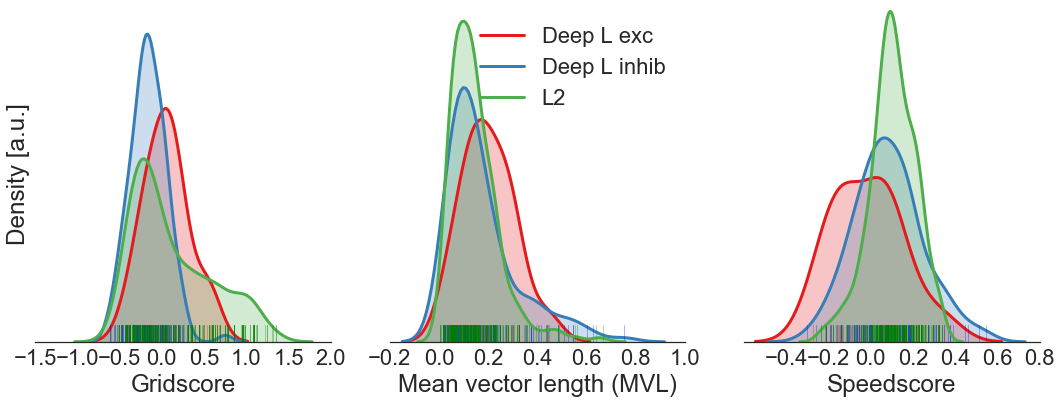

In [13]:
sns.set(font_scale=2.2)
sns.set_style('white')
sns.set_palette('Set1')
figure = plt.figure(figsize=(18,6))
ax = figure.add_subplot(1,3,1)
ax = sns.kdeplot(deep_layer_exc_bnt_scores_cells.gridscore.dropna(), shade=True,label='Deep L exc',lw=3)
ax = sns.rugplot(deep_layer_exc_bnt_scores_cells.gridscore.dropna(),lw=1,color='r',alpha=.3)

ax = sns.kdeplot(deep_layer_inhib_bnt_scores_cells.gridscore.dropna(), shade=True,label='Deep L inhib',lw=3)
ax = sns.rugplot(deep_layer_inhib_bnt_scores_cells.gridscore.dropna(),lw=1,color='b',alpha=.3)

ax = sns.kdeplot(sup_layer_bnt_scores_cells.gridscore.dropna(), 
                 shade=True,label='L2',lw=3)
ax = sns.rugplot(sup_layer_bnt_scores_cells.gridscore.dropna(),lw=1,color='g',alpha=.3)
ax.legend_.remove()

ax.set_xlabel('Gridscore')
ax.set_ylabel('Density [a.u.]')
ax.get_yaxis().set_ticks([])

ax = figure.add_subplot(1,3,2)
ax = sns.kdeplot(deep_layer_exc_bnt_scores_cells.mvl.dropna(), shade=True,label='Deep L exc',lw=3)
ax = sns.rugplot(deep_layer_exc_bnt_scores_cells.mvl.dropna(),lw=1,color='r',alpha=.3)

ax = sns.kdeplot(deep_layer_inhib_bnt_scores_cells.mvl.dropna(), shade=True, label='Deep L inhib',lw=3)
ax = sns.rugplot(deep_layer_inhib_bnt_scores_cells.mvl.dropna(),lw=1,color='b',alpha=.3)

ax = sns.kdeplot(sup_layer_bnt_scores_cells.mvl.dropna(), 
                 shade=True,label='L2',lw=3)
ax = sns.rugplot(sup_layer_bnt_scores_cells.mvl.dropna(),lw=1,color='g',alpha=.3)

ax.set_xlabel('Mean vector length (MVL)')
ax.get_yaxis().set_ticks([])
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
ax.legend_.remove()
ax.legend(loc=1)

ax = figure.add_subplot(1,3,3)
ax = sns.kdeplot(deep_layer_exc_bnt_scores_cells.speedscore.dropna(), shade=True,label='Deep L exc',lw=3)
ax = sns.rugplot(deep_layer_exc_bnt_scores_cells.speedscore.dropna(),lw=1,color='r',alpha=.3)

ax = sns.kdeplot(deep_layer_inhib_bnt_scores_cells.speedscore.dropna(), shade=True, label='Deep L inhib',lw=3)
ax = sns.rugplot(deep_layer_inhib_bnt_scores_cells.speedscore.dropna(),lw=1,color='b',alpha=.3)

ax = sns.kdeplot(sup_layer_bnt_scores_cells.speedscore.dropna(), 
                 shade=True,label='L2',lw=3)
ax = sns.rugplot(sup_layer_bnt_scores_cells.speedscore.dropna(),lw=1,color='g',alpha=.3)

ax.set_xlabel('Speedscore')
ax.get_yaxis().set_ticks([])
ax.set_xlim((-.6,.8))
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
ax.legend_.remove()

sns.despine(left=True)

### autocorr scores 

In [14]:
sup_layer_autocorr_cells.columns

Index([u'cluster_no', u'analysis_ts', u'tetrode_no', u'session_name',
       u'filename', u'n_drive_user', u'animal_id', u'session_ts',
       u'analysis_window', u'salt_window', u'sample_rate', u'sample_rate_inp',
       u'ibi', u'stim_freq', u'stim_length', u'counter_stimuli', u'excited',
       u'salt_p', u'salt_i', u'ex_latency_mean', u'ex_latency_median',
       u'ex_latency_var', u'ex_latency_reliabil', u'stats_p_inhib_10',
       u'stats_p_inhib_20', u'stats_p_inhib_30', u'stats_p_inhib_40',
       u'inhibited', u'inhib_lowest_p', u'inhib_lowest_p_interval',
       u'change_point_ms', u'spiketimes_cluster', u'stimulus_timepoints',
       u'sum_1ms', u'bin_edges_1ms', u'binnumber_1ms', u'theta_idx',
       u'burst_idx1', u'burst_idx2'],
      dtype='object')

In [15]:
deep_layer_inhib_autocorr_cells = deep_layer_autocorr_cells[deep_layer_autocorr_cells.inhibited == True]
deep_layer_exc_autocorr_cells = deep_layer_autocorr_cells[deep_layer_autocorr_cells.excited == True]

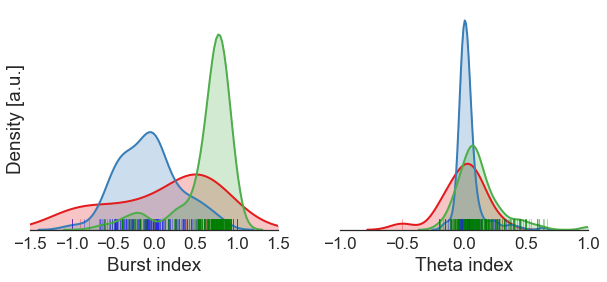

In [16]:
sns.set(font_scale=1.7)
sns.set_style('white')
sns.set_palette('Set1')
figure = plt.figure(figsize=(10,4))
ax = figure.add_subplot(1,2,1)
ax = sns.kdeplot(deep_layer_exc_autocorr_cells.burst_idx1.dropna(), shade=True,label='Deep L exc',lw=2)
ax = sns.rugplot(deep_layer_exc_autocorr_cells.burst_idx1.dropna(),lw=1,color='r',alpha=.3)

ax = sns.kdeplot(deep_layer_inhib_autocorr_cells.burst_idx1.dropna(), shade=True, label='Deep L inhib',lw=2)
ax = sns.rugplot(deep_layer_inhib_autocorr_cells.burst_idx1.dropna(),lw=1,color='b',alpha=.3)

ax = sns.kdeplot(sup_layer_autocorr_cells.burst_idx1.dropna(), 
                 shade=True,label='L2',lw=2)
ax = sns.rugplot(sup_layer_autocorr_cells.burst_idx1.dropna(),lw=1,color='g',alpha=.3)

ax.set_xlabel('Burst index')
ax.set_xlim((-1.5,1.5))

ax.set_ylabel('Density [a.u.]')
ax.get_yaxis().set_ticks([])
ax.legend_.remove()

ax = figure.add_subplot(1,2,2)
ax = sns.kdeplot(deep_layer_exc_autocorr_cells.theta_idx.dropna(), shade=True,label='Deep L exc',lw=2)
ax = sns.rugplot(deep_layer_exc_autocorr_cells.theta_idx.dropna(),lw=1,color='r',alpha=.3)

ax = sns.kdeplot(deep_layer_inhib_autocorr_cells.theta_idx.dropna(), shade=True, label='Deep L inhib',lw=2)
ax = sns.rugplot(deep_layer_inhib_autocorr_cells.theta_idx.dropna(),lw=1,color='b',alpha=.3)

ax = sns.kdeplot(sup_layer_autocorr_cells.theta_idx.dropna(), 
                 shade=True,label='L2',lw=2)
ax = sns.rugplot(sup_layer_autocorr_cells.theta_idx.dropna(),lw=1,color='g',alpha=.3)
ax.set_xlim((-1,1))
ax.set_xlabel('Theta index')
ax.get_yaxis().set_ticks([])
ax.legend_.remove()

figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)

sns.despine(left=True)

### Scatter plot: peak firing burstiness

In [46]:
# get datasets to plot
deep_exc_theta = deep_layer_exc_autocorr_cells.theta_idx.dropna()[:len(deep_layer_exc_bnt_scores_cells.peakrate.dropna())]
deep_exc_burst = deep_layer_exc_autocorr_cells.burst_idx1.dropna()[:len(deep_layer_exc_bnt_scores_cells.peakrate.dropna())]
deep_exc_peak = deep_layer_exc_bnt_scores_cells.peakrate.dropna()

deep_inhib_theta = deep_layer_inhib_autocorr_cells.theta_idx.dropna()[:len(deep_layer_inhib_bnt_scores_cells.peakrate.dropna())]
deep_inhib_burst = deep_layer_inhib_autocorr_cells.burst_idx1.dropna()[:len(deep_layer_inhib_bnt_scores_cells.peakrate.dropna())]
deep_inhib_peak = deep_layer_inhib_bnt_scores_cells.peakrate.dropna()

sup_inhib_theta = sup_layer_autocorr_cells.theta_idx.dropna()[:len(sup_layer_bnt_scores_cells.peakrate.dropna())]
sup_inhib_burst = sup_layer_autocorr_cells.burst_idx1.dropna()[:len(sup_layer_bnt_scores_cells.peakrate.dropna())]
sup_inhib_peak = sup_layer_bnt_scores_cells.peakrate.dropna()

In [39]:
# normalize:
deep_exc_theta = (deep_exc_theta - np.mean(deep_exc_theta)) / np.std(deep_exc_theta)
deep_exc_burst = (deep_exc_burst - np.mean(deep_exc_burst)) / np.std(deep_exc_burst)
deep_exc_peak = (deep_exc_peak - np.mean(deep_exc_peak)) / np.std(deep_exc_peak)

deep_inhib_theta = (deep_inhib_theta - np.mean(deep_inhib_theta)) / np.std(deep_inhib_theta)
deep_inhib_burst = (deep_inhib_burst - np.mean(deep_inhib_burst)) / np.std(deep_inhib_burst)
deep_inhib_peak = (deep_inhib_peak - np.mean(deep_inhib_peak)) / np.std(deep_inhib_peak)

sup_inhib_theta = (sup_inhib_theta - np.mean(sup_inhib_theta)) / np.std(sup_inhib_theta)
sup_inhib_burst = (sup_inhib_burst - np.mean(sup_inhib_burst)) / np.std(sup_inhib_burst)
sup_inhib_peak = (sup_inhib_peak - np.mean(sup_inhib_peak)) / np.std(sup_inhib_peak)

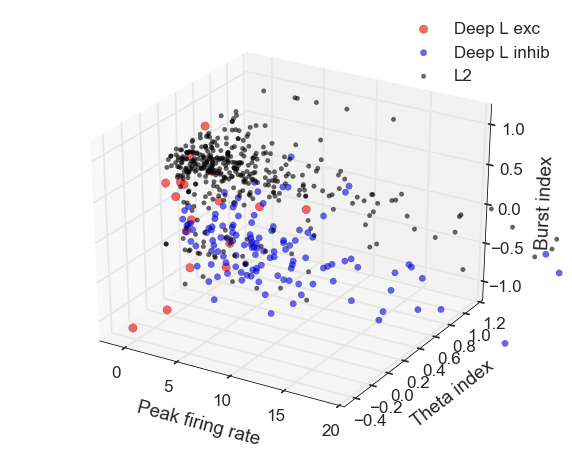

In [55]:
from mpl_toolkits.mplot3d import Axes3D

sns.set(font_scale=1.7)
sns.set_style('white')
sns.set_palette('Set1')

figure = plt.figure(figsize=(10,8))
ax = figure.add_subplot(1,1,1,projection='3d')
ax.scatter(deep_exc_peak,deep_exc_theta,deep_exc_burst,c='r',alpha=.6,s=70,label='Deep L exc')
ax.scatter(deep_inhib_peak,deep_inhib_theta,deep_inhib_burst,c='b',alpha=.6,s=40,label='Deep L inhib')
ax.scatter(sup_inhib_peak,sup_inhib_theta,sup_inhib_burst,c='k',alpha=.6,label='L2')
ax.view_init(30, -59)

ax.set_xlim((-2,20))
ax.set_xlabel('\n\nPeak firing rate')

ax.set_ylim((-.5,1.2))
ax.set_ylabel('\n\nTheta index')
ax.set_zlim((-1.2,1.2))
ax.set_zlabel('\n\nBurst index')
ax.dist = 11
ax.legend()


In [56]:
# retrieve an example autocorrelation
sup_layer_autocorr_cells.sort_values(by='burst_idx1').burst_idx1.dropna().values.min()

-0.78494623655899998

In [57]:
sup_layer_autocorr_cells.sort_values(by='theta_idx').theta_idx.dropna().values.max()

1.0

### calculate average burstiness thetaidx

In [59]:
autocorr_complete_cells = pd.DataFrame()

# concatenate three datasets for every dataframe...

for df in tqdm_notebook([sup_layer_autocorr_cells,deep_layer_inhib_autocorr_cells,deep_layer_exc_autocorr_cells]):
    for i in tqdm_notebook(xrange(len(df))):
        c_entry = df.iloc[i]
        # retrieve the base session stats:
        # autocorr_complete_cells (st_autocorr_tb):
        sql = "SELECT st_autocorr FROM st_autocorr_tb \
              WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
              session_ts = '{}' AND session_name NOT LIKE '%las%' AND session_name \
              NOT LIKE '%obj%';".format(c_entry.animal_id, c_entry.cluster_no,c_entry.tetrode_no, c_entry.session_ts)

        c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None)
        if len(c_sql) > 1: sys.exit()
        if len(c_sql) != 0: 
            # concat the new with the old dataframe:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_join = pd.concat([c_entry_T,c_sql[['st_autocorr']]],axis=1) # horizontally join the two entries
            autocorr_complete_cells = pd.concat([autocorr_complete_cells,  c_join], axis=0) # vertically join it with the rest
        else:
            c_entry_T = pd.DataFrame(c_entry).T
            c_entry_T.reset_index(inplace=True,drop=True)
            c_entry_T['st_autocorr'] = np.nan
            autocorr_complete_cells = pd.concat([autocorr_complete_cells,  c_entry_T], axis=0) # vertically join it with the rest         
        
    
print('Finished.')


Finished.


## you now have: 
- autocorr_complete_cells

based upon
- sup_layer_autocorr_cells
- deep_layer_inhib_autocorr_cells
- deep_layer_exc_autocorr_cells

In [60]:
autocorr_complete_sup_layer = autocorr_complete_cells.iloc[:len(sup_layer_autocorr_cells)]
autocorr_complete_deep_layer_inhib = autocorr_complete_cells.iloc[len(sup_layer_autocorr_cells):len(sup_layer_autocorr_cells)+len(deep_layer_inhib_autocorr_cells)]
autocorr_complete_deep_layer_exc = autocorr_complete_cells.iloc[len(sup_layer_autocorr_cells)+len(deep_layer_inhib_autocorr_cells):]

In [61]:
print(len(sup_layer_autocorr_cells),len(autocorr_complete_sup_layer))
print(len(deep_layer_inhib_autocorr_cells),len(autocorr_complete_deep_layer_inhib))
print(len(deep_layer_exc_autocorr_cells),len(autocorr_complete_deep_layer_exc))

532 532
157 157
19 19


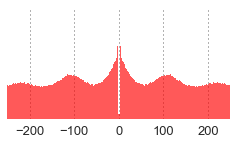

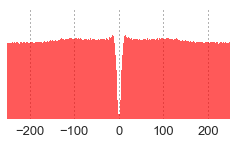

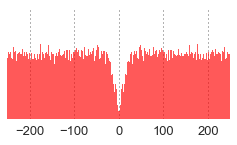

In [66]:
for no,df in enumerate([autocorr_complete_sup_layer,autocorr_complete_deep_layer_inhib,autocorr_complete_deep_layer_exc]):
    
    figure = plt.figure(figsize=(4,2))
    sns.set(font_scale=1.3)
    sns.set_style('white')

    ax = figure.add_subplot(1,1,1)

    ax.bar(np.arange(501) - 250, np.mean(df.st_autocorr), width=1.001, ec='none',color='red',alpha=.65);
    ax.set_xlim(-250,250)
    [y1,y2] = ax.get_ylim()
    ax.set_ylim(0,1.3*y2)
    #ax.xaxis.set_visible(False)

    ax.axes.get_yaxis().set_visible(False)
    ax.grid(color='k', linestyle=':', linewidth=1,alpha=.6)

    sns.despine(left=True, bottom=True, right=True,top=True)
    plt.show()

In [ ]:
np.mean(autocorr_complete_cells.st_autocorr)